In [2]:
import sys
import random
import csv
import pandas as pd
import json
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns

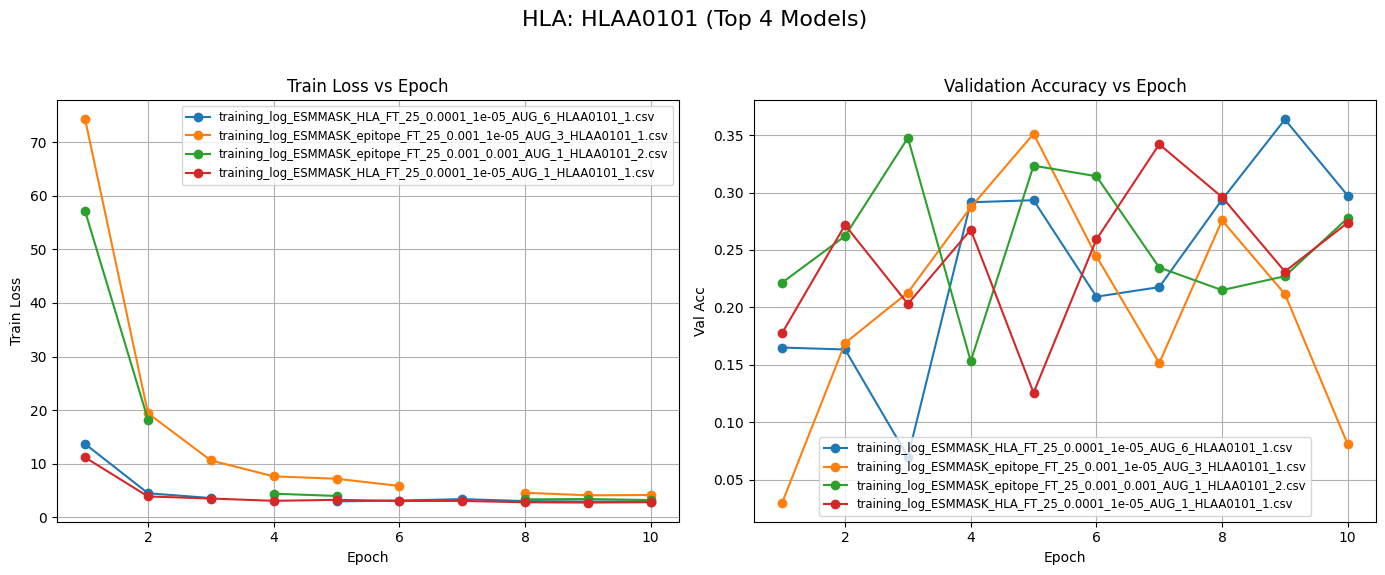

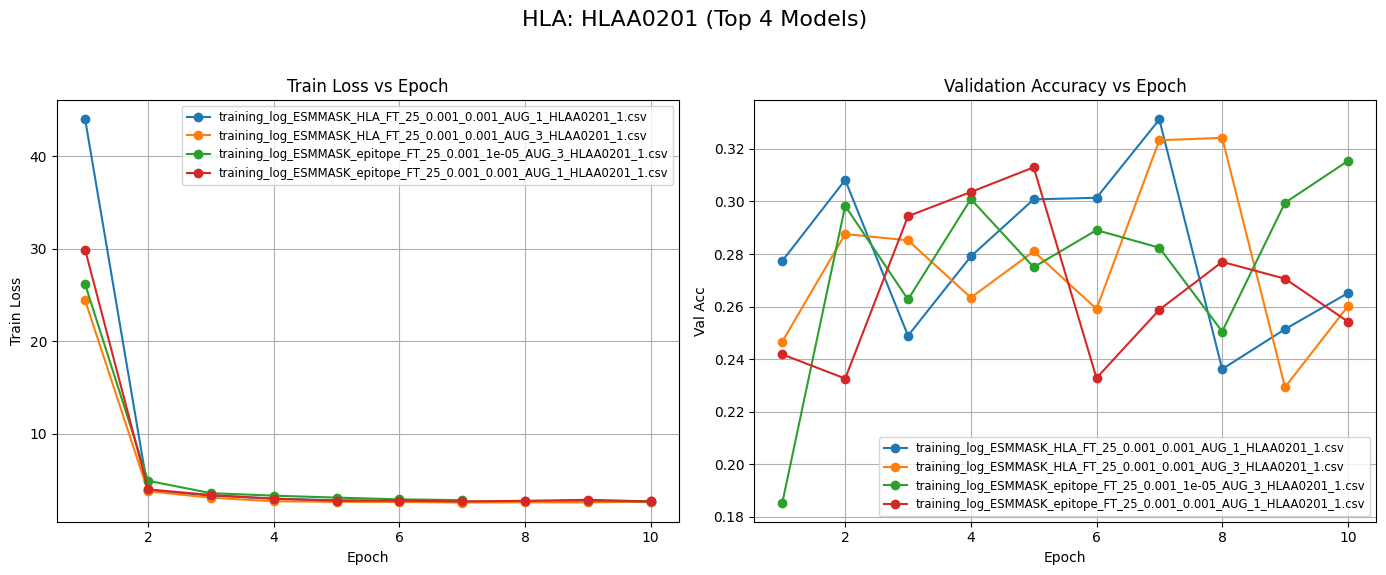

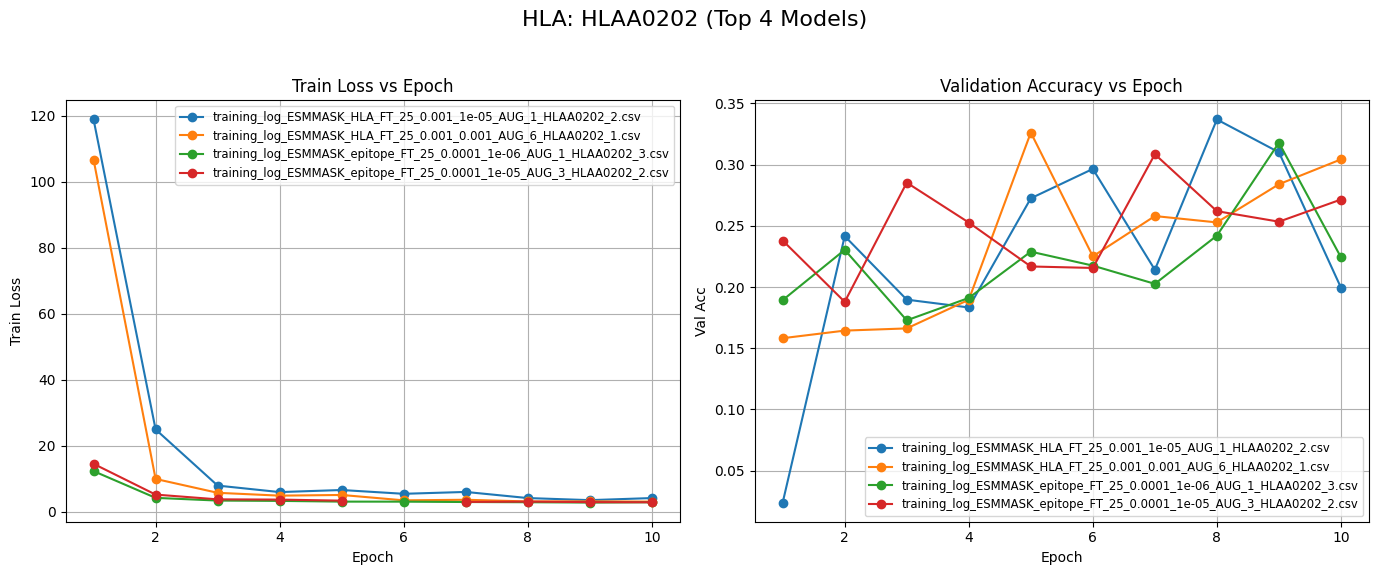

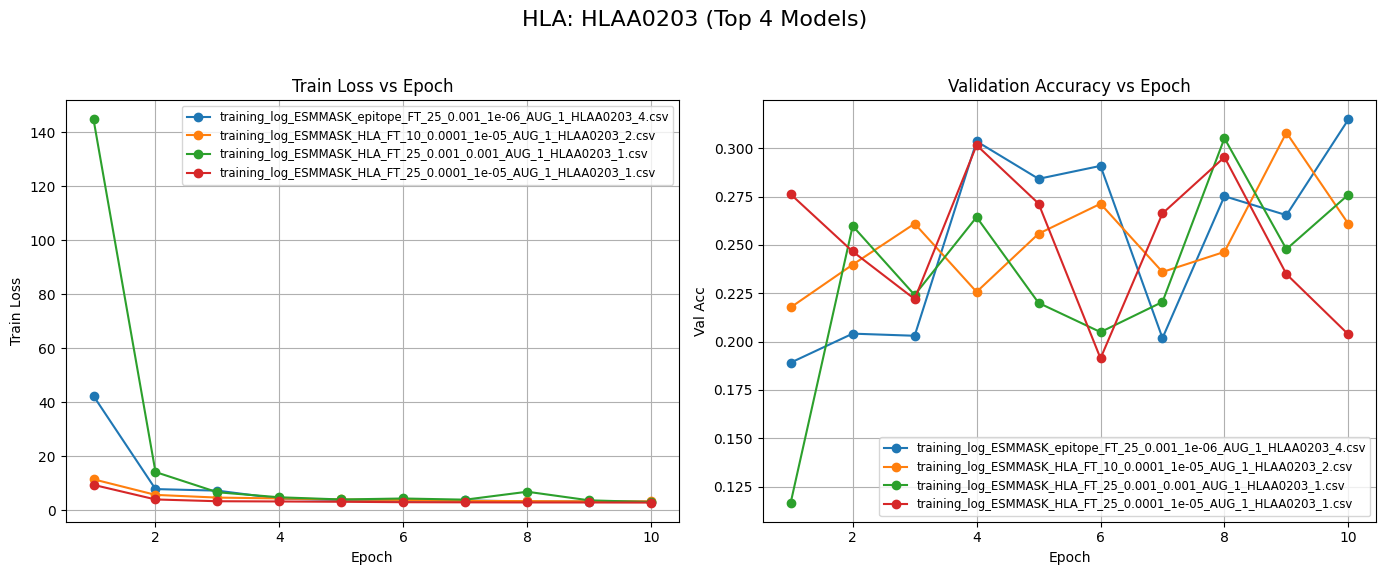

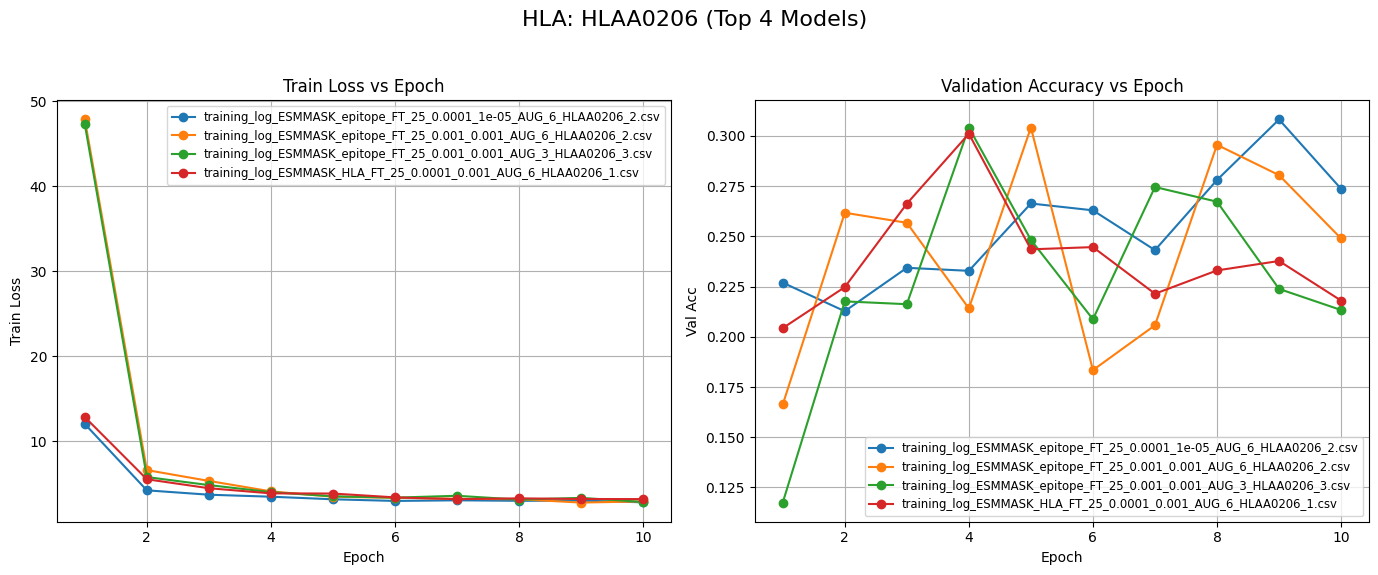

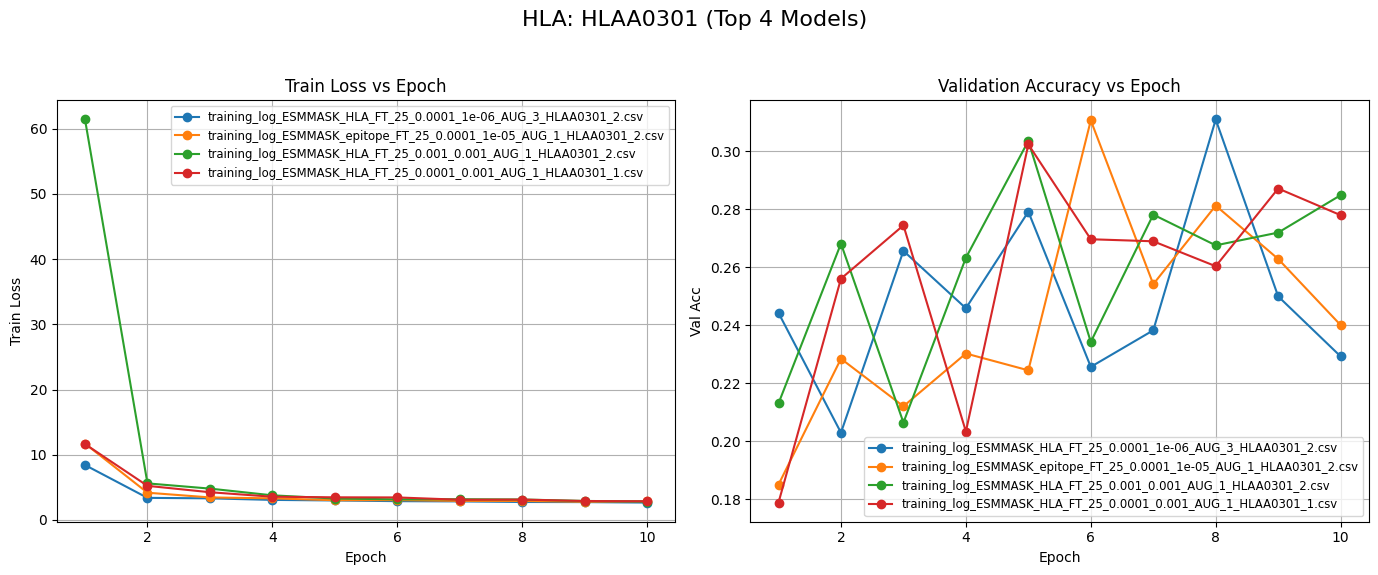

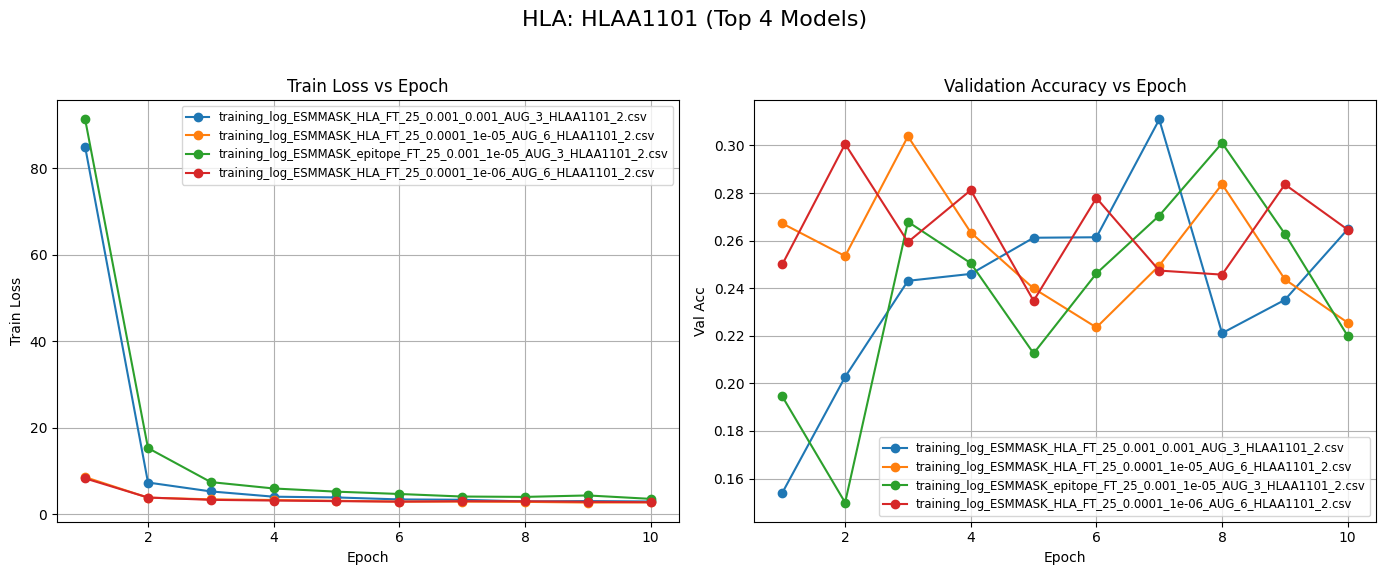

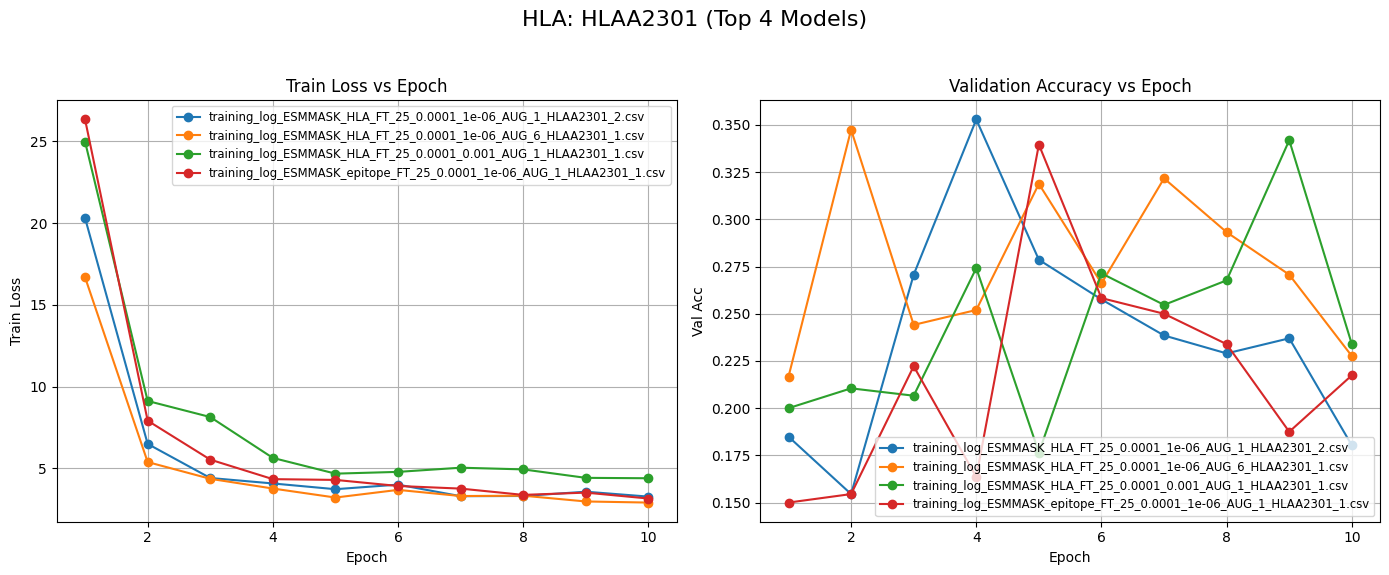

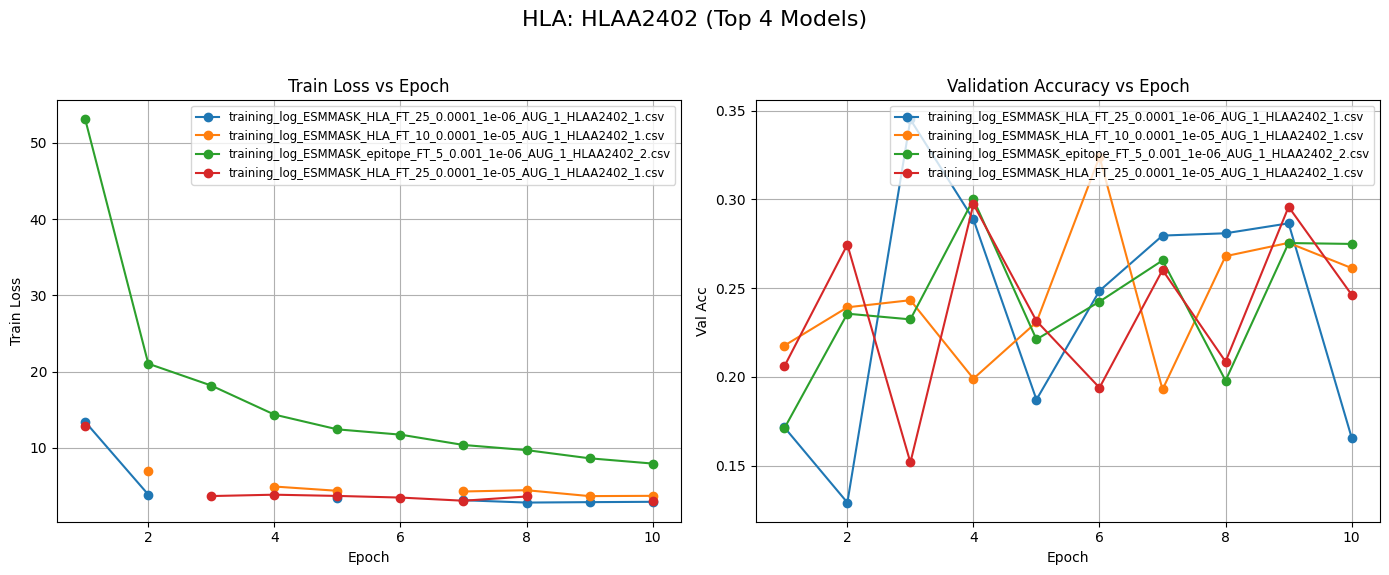

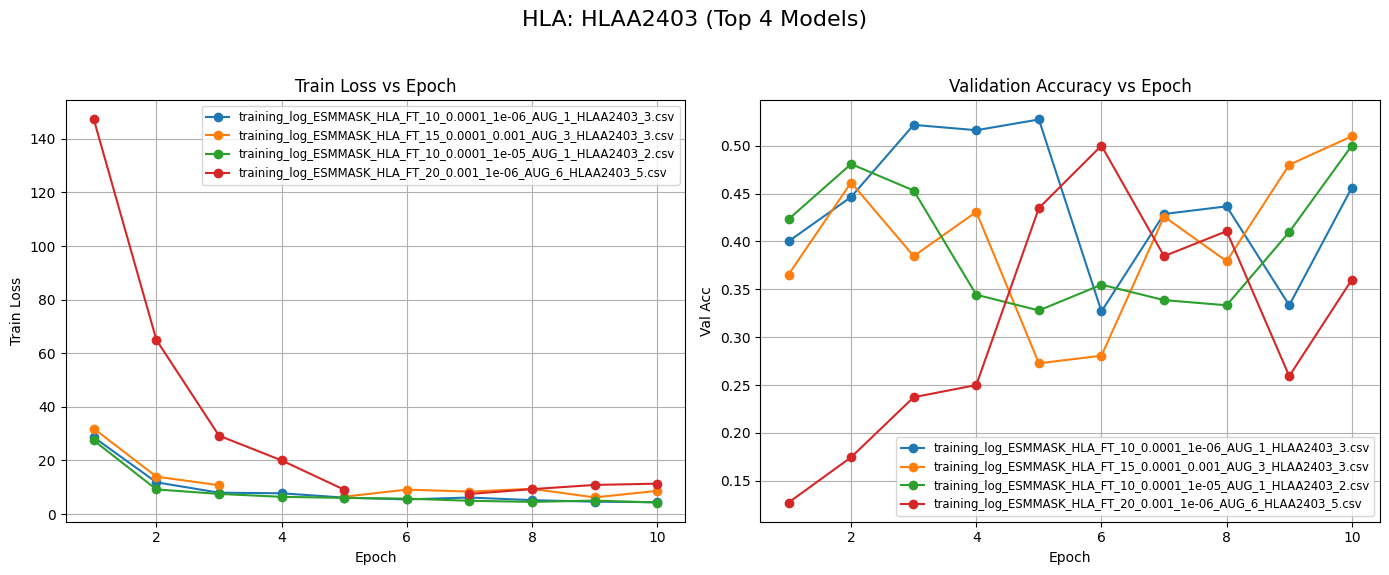

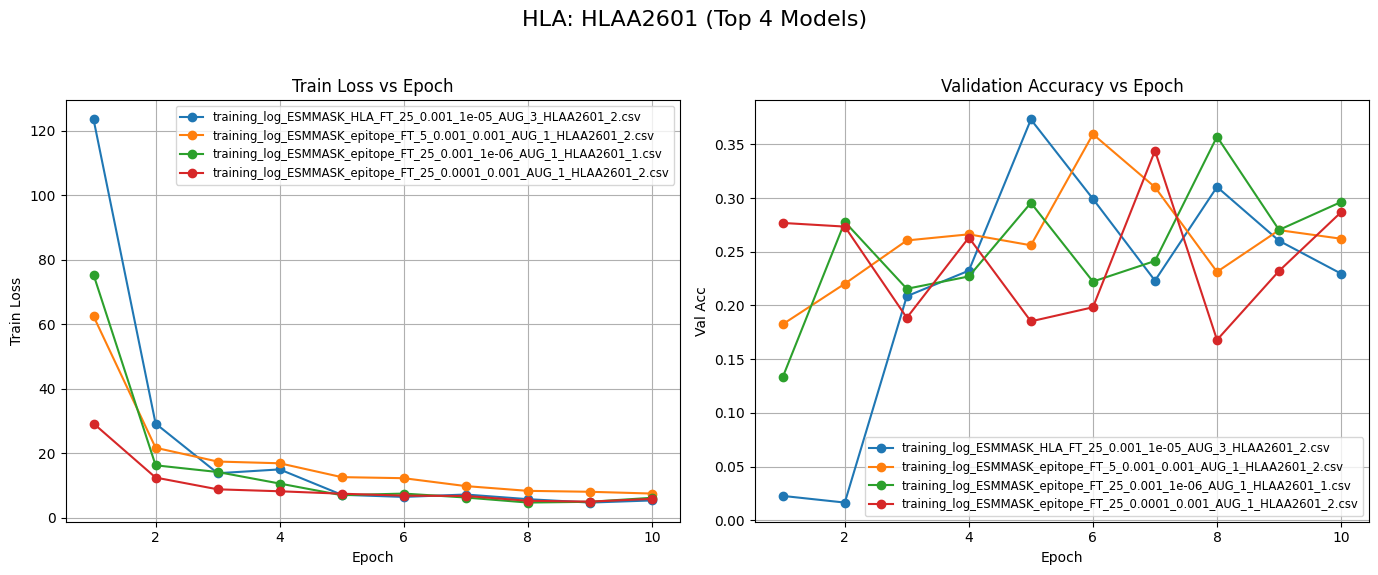

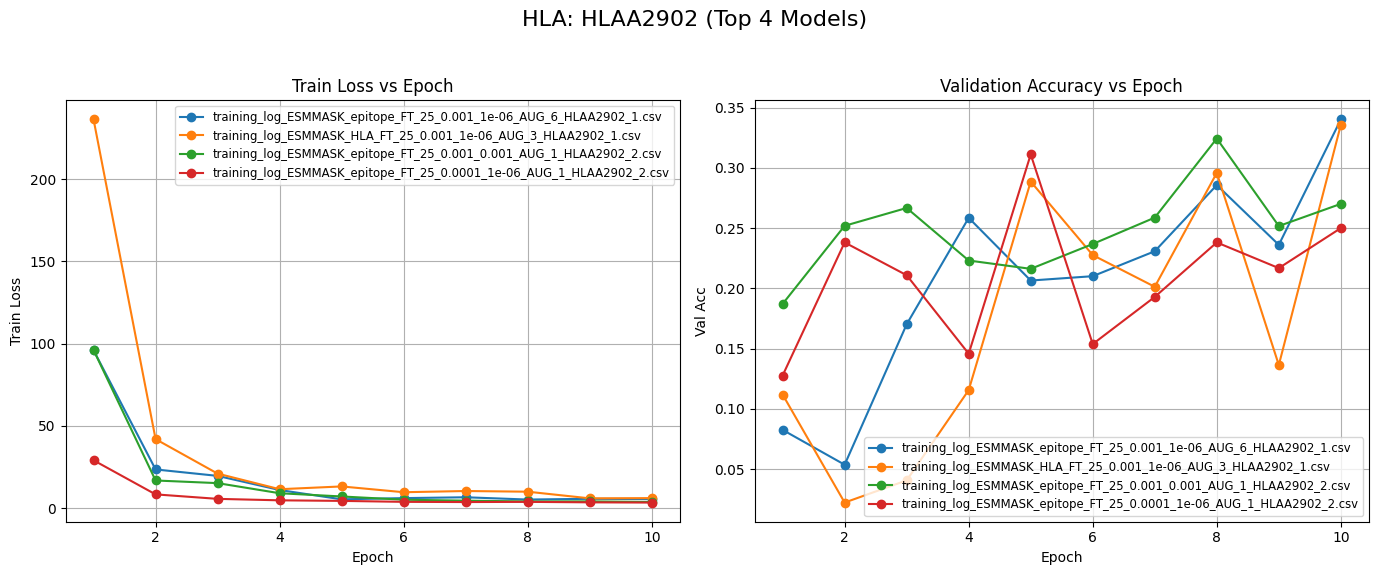

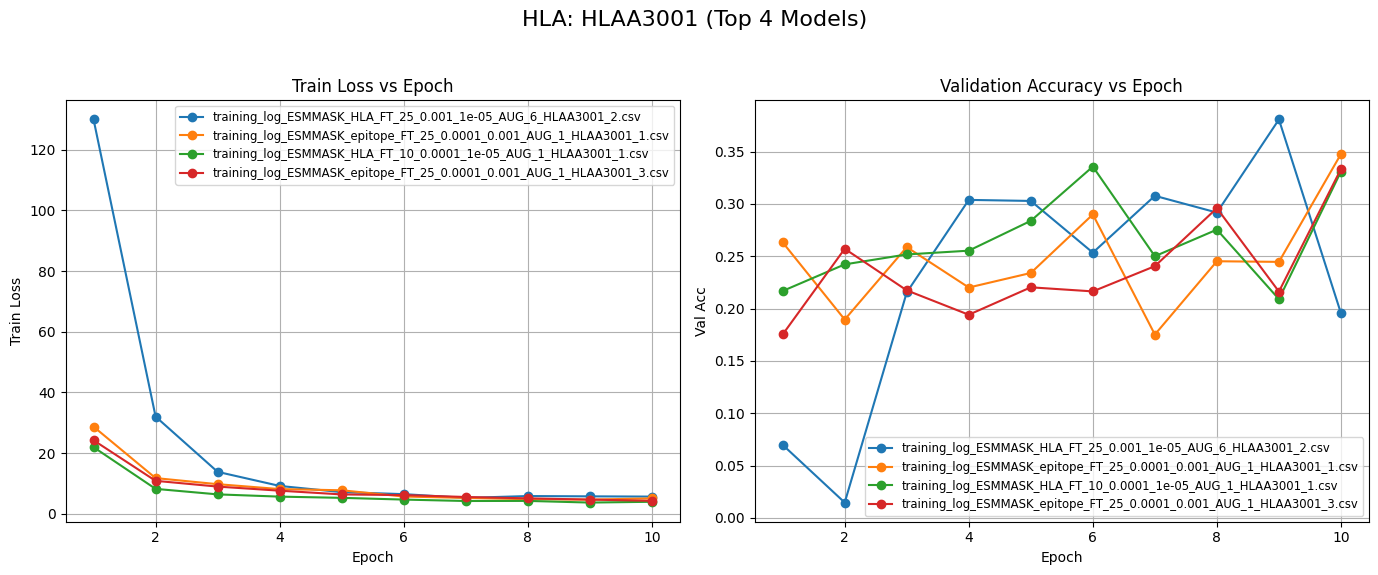

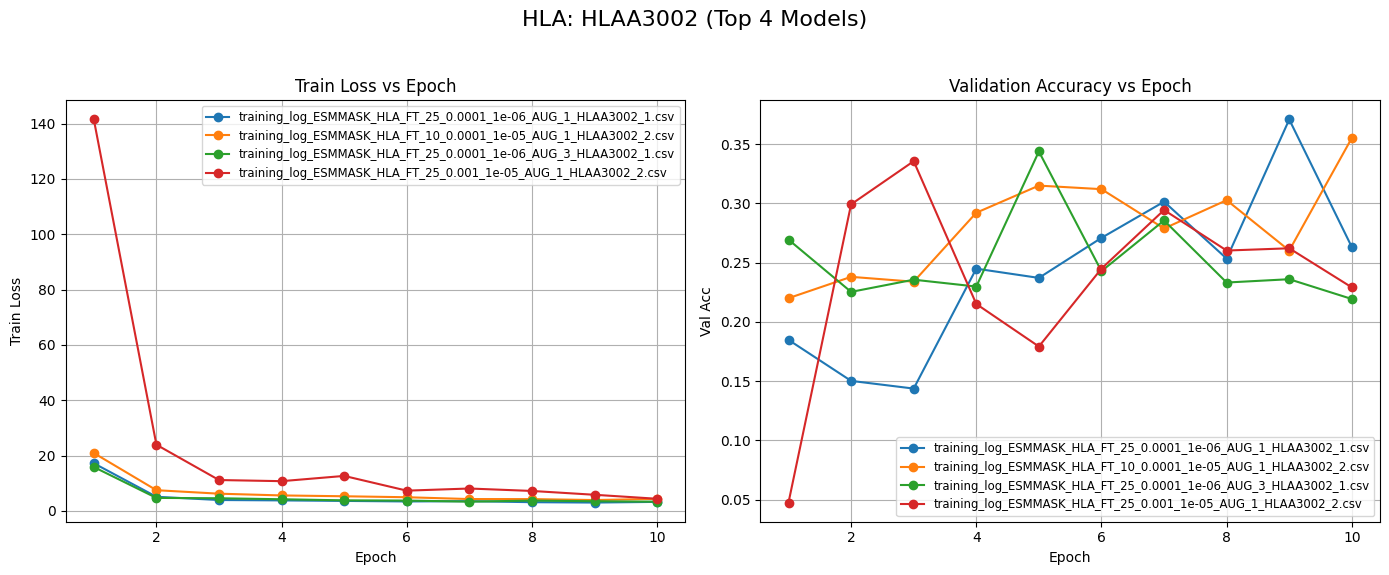

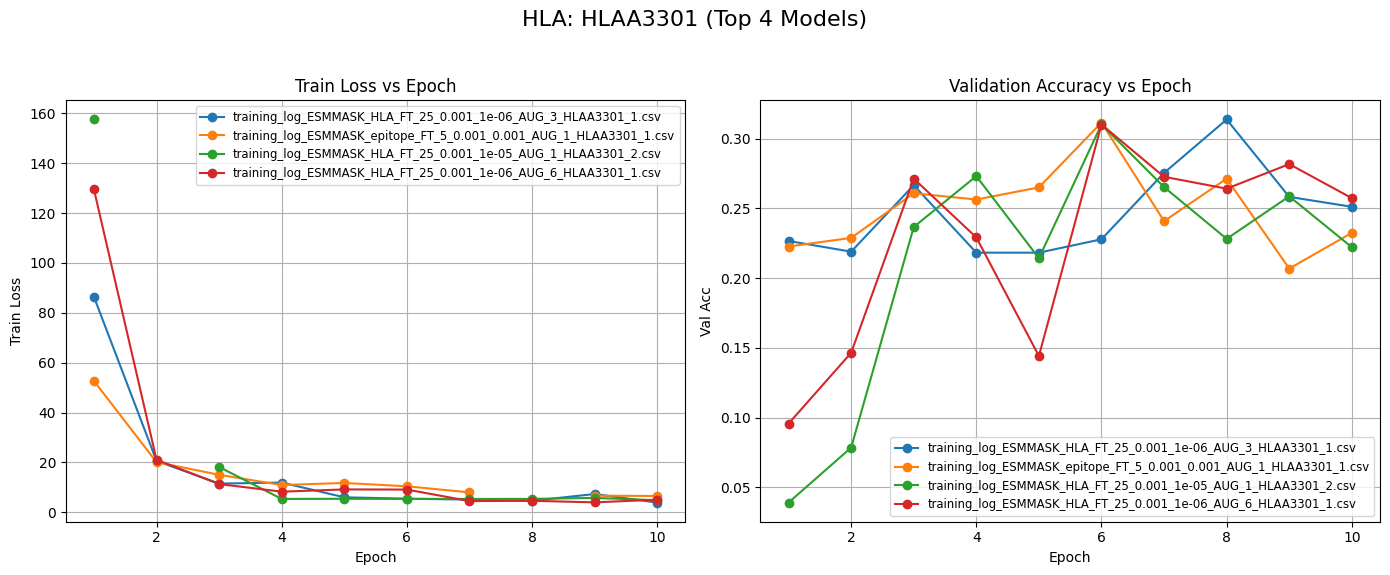

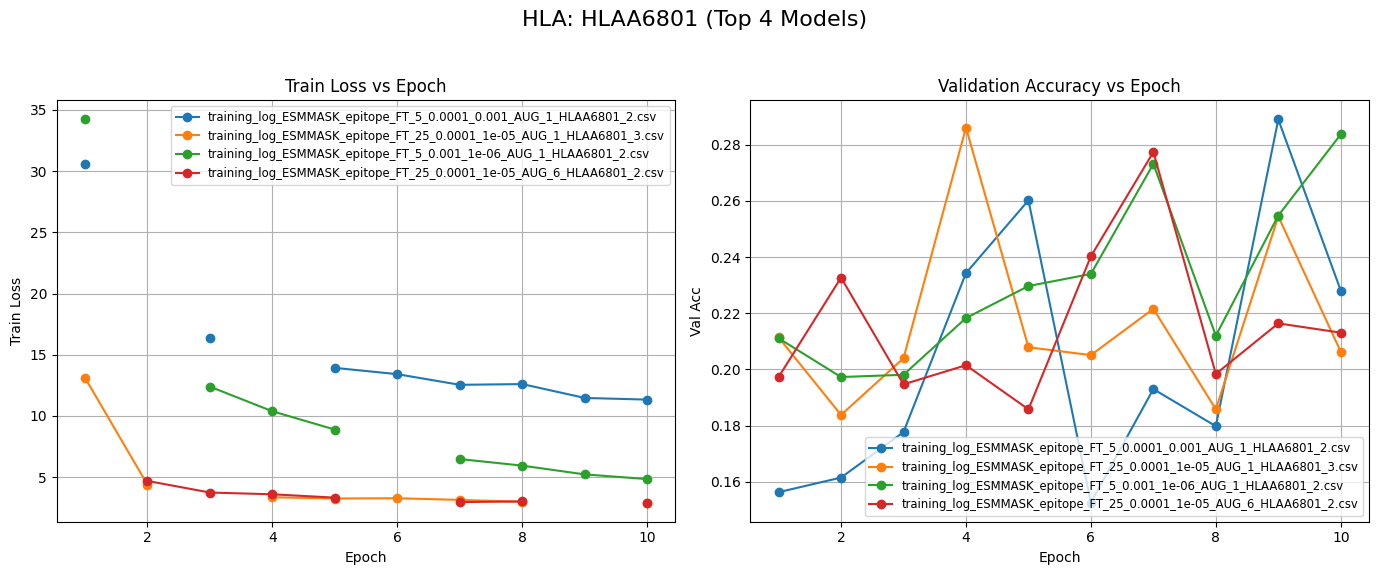

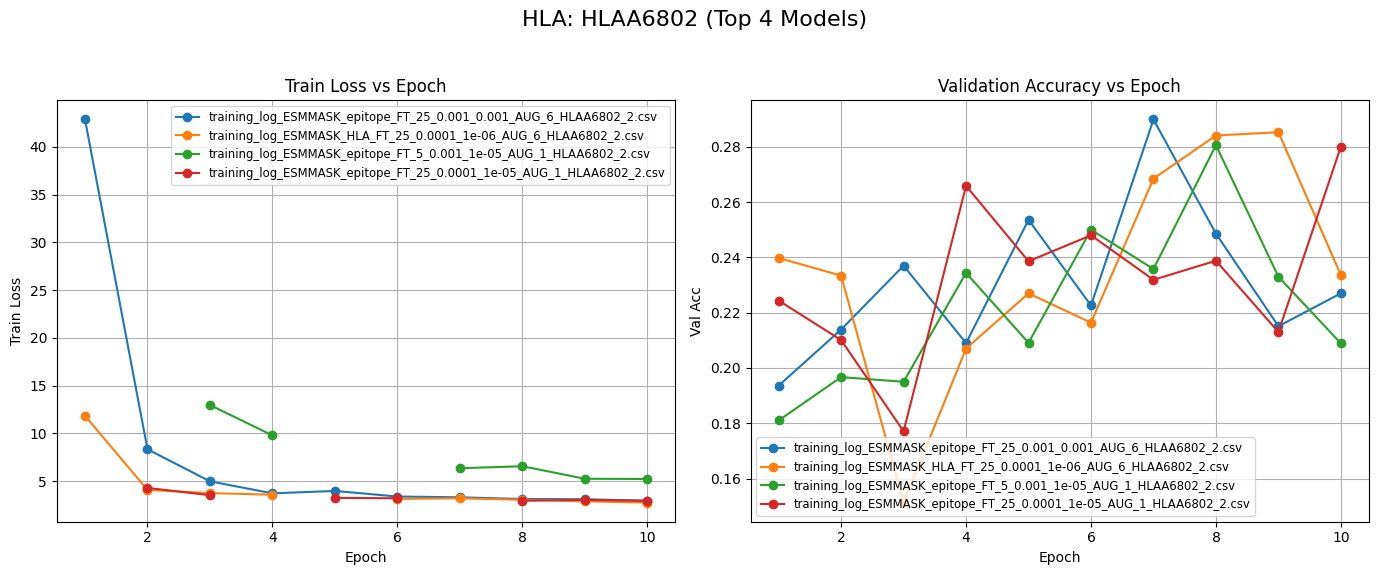

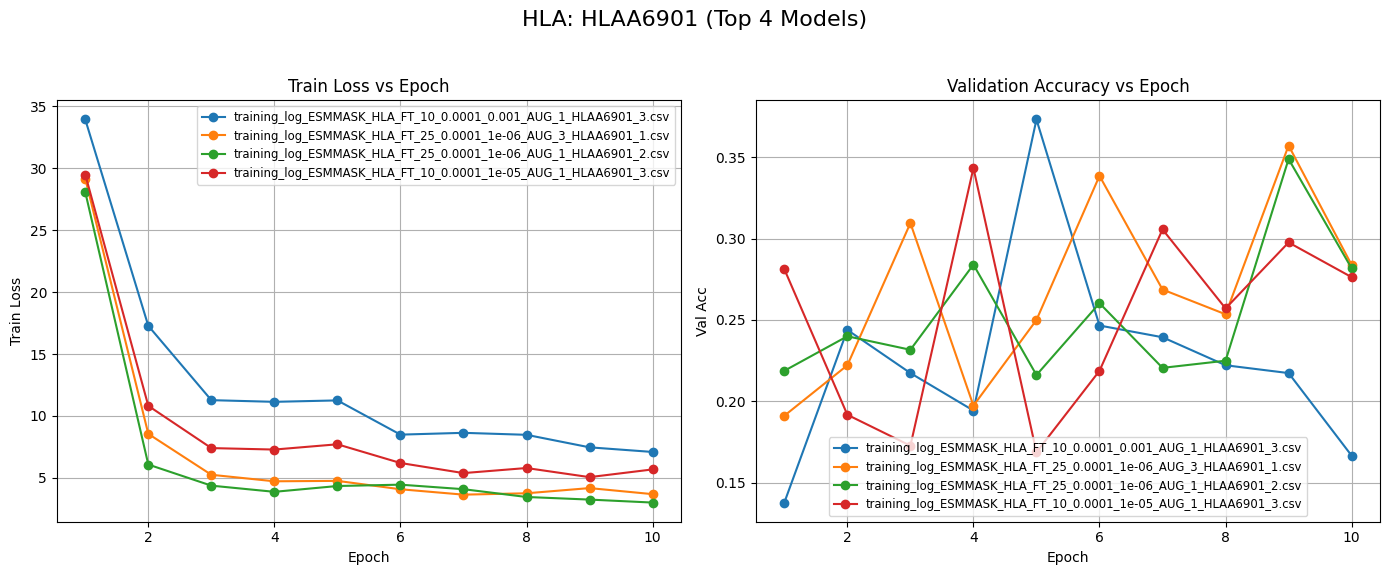

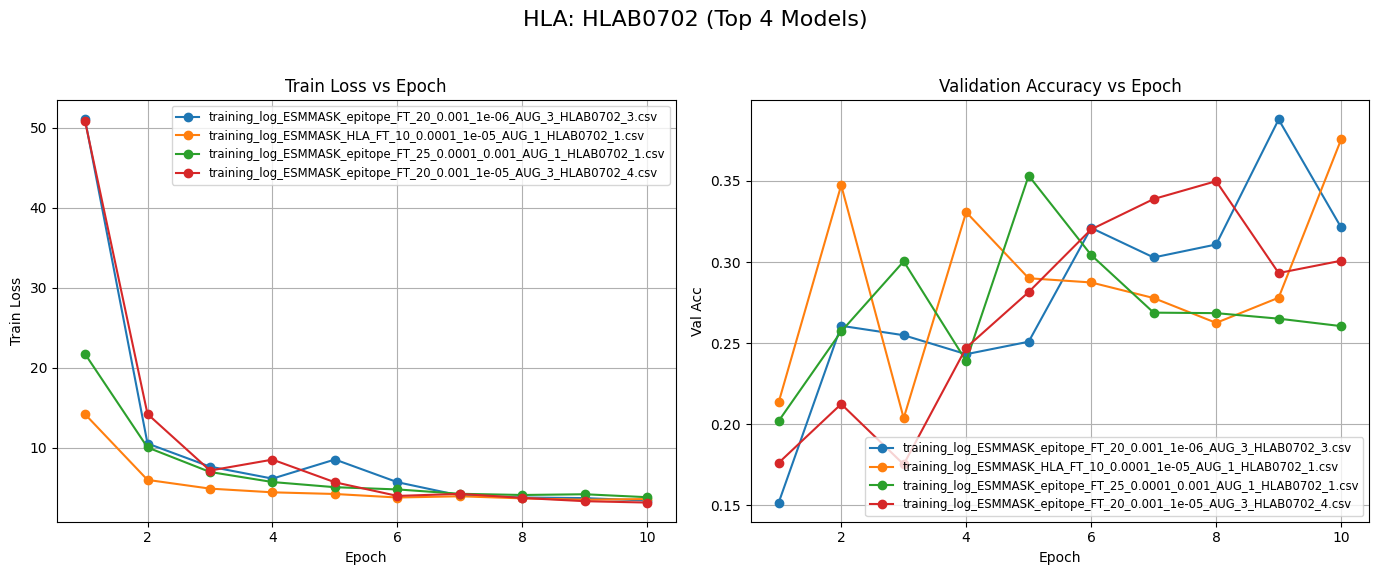

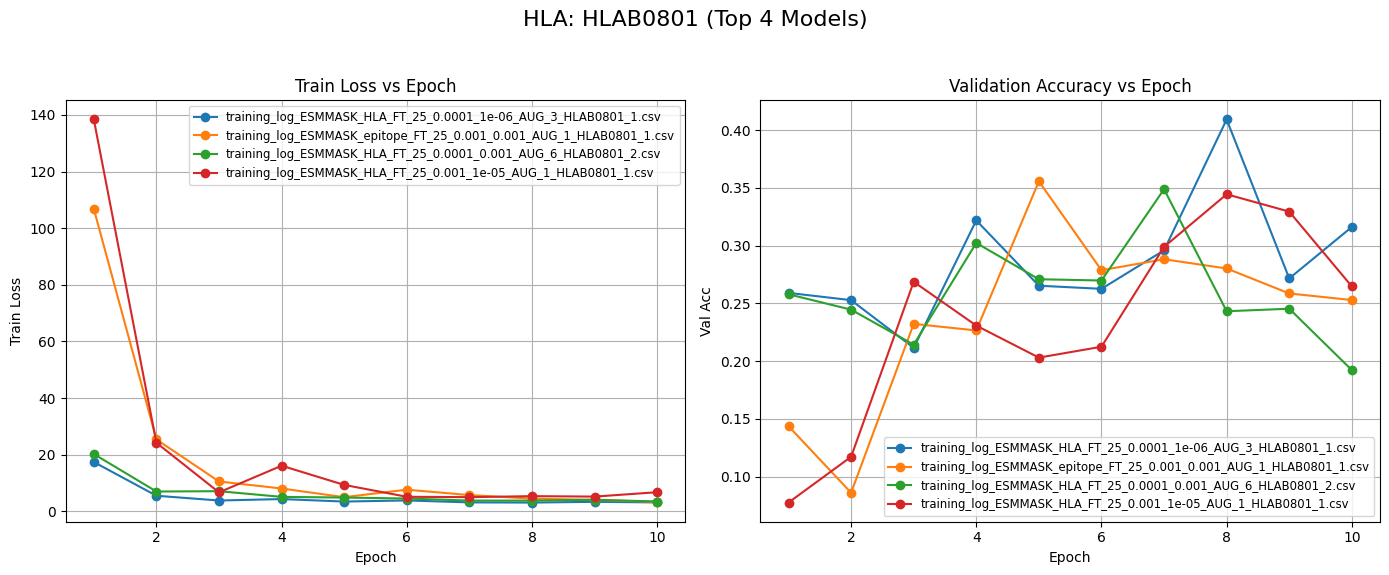

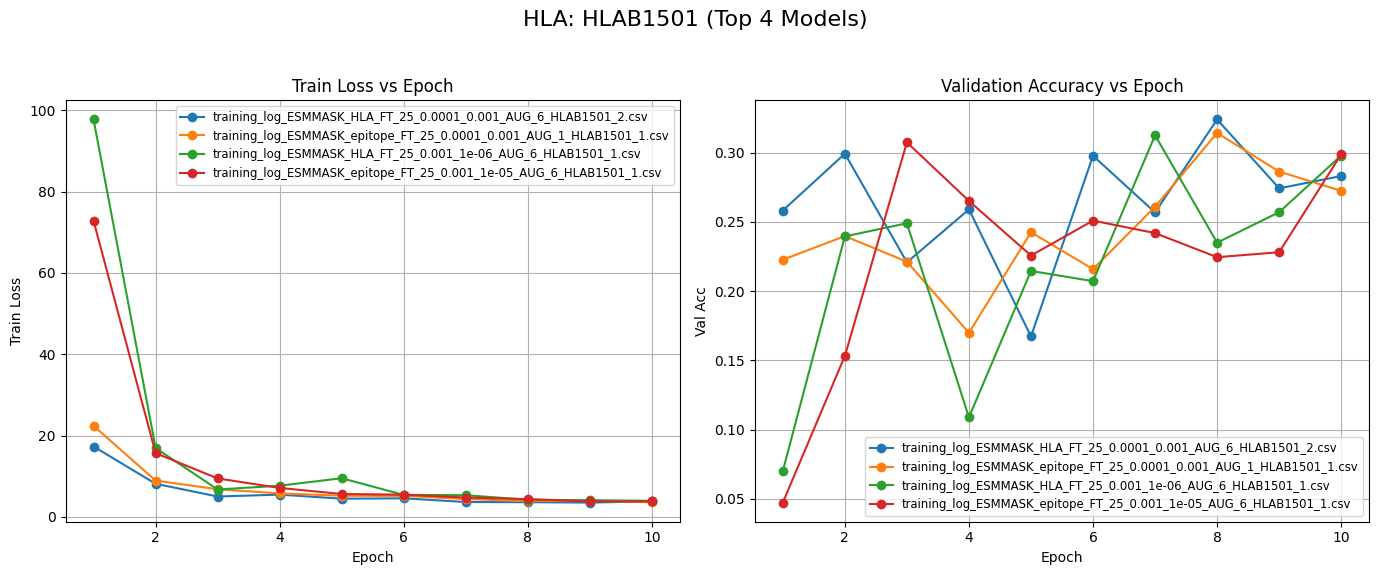

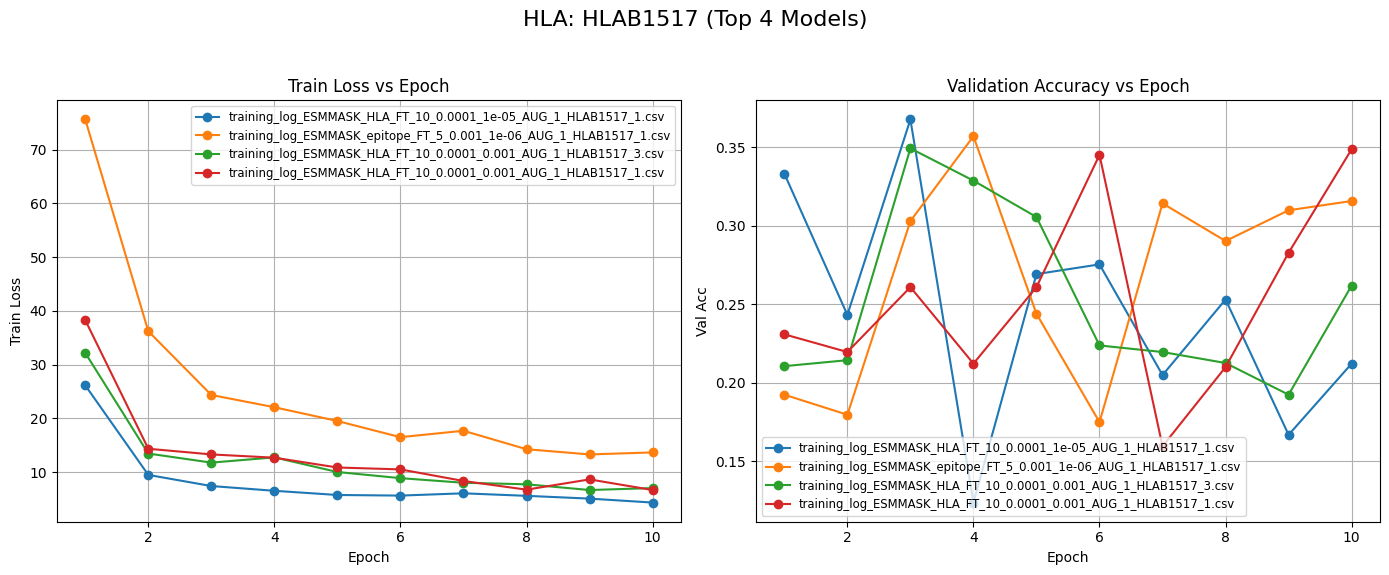

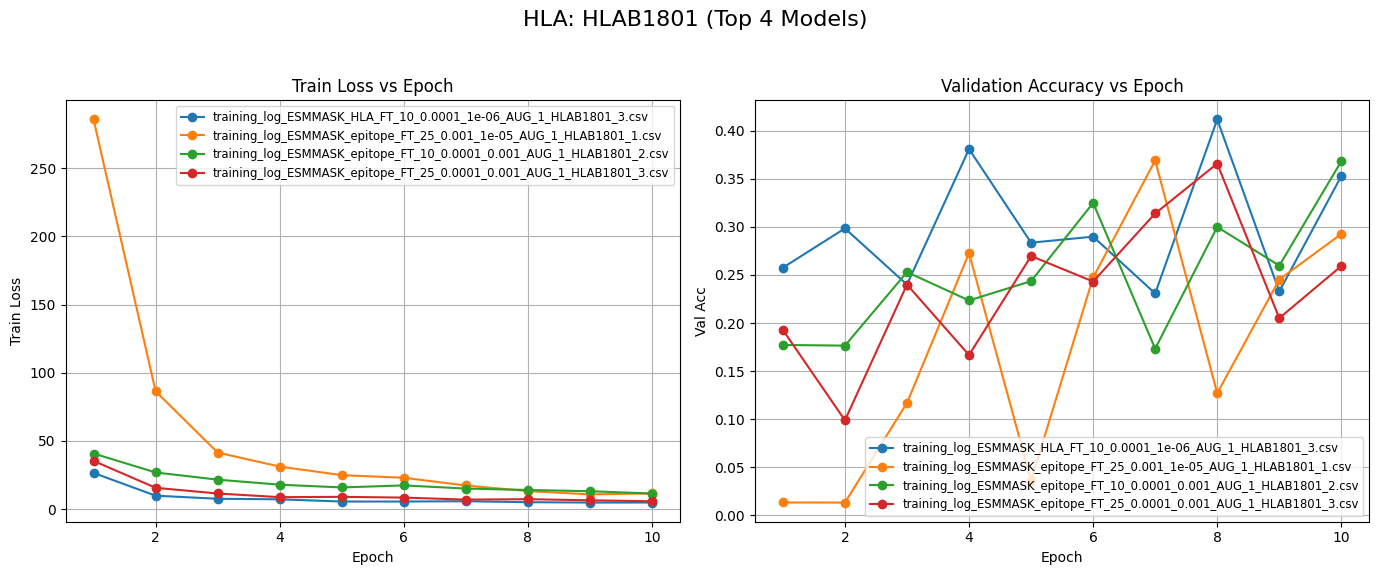

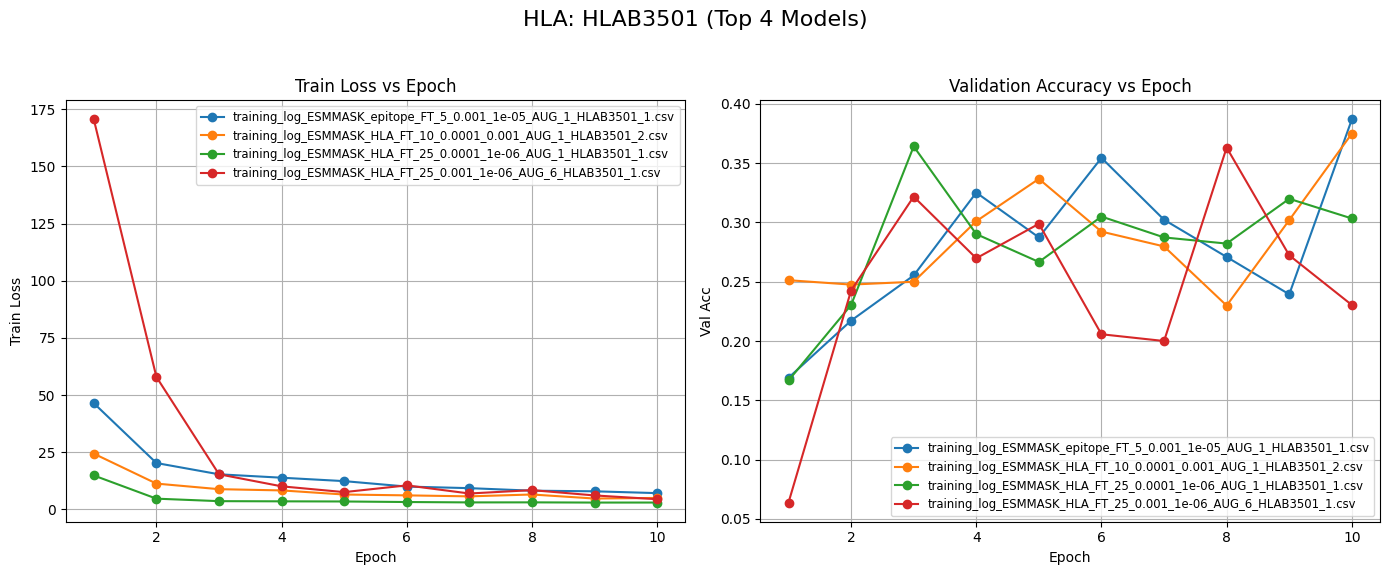

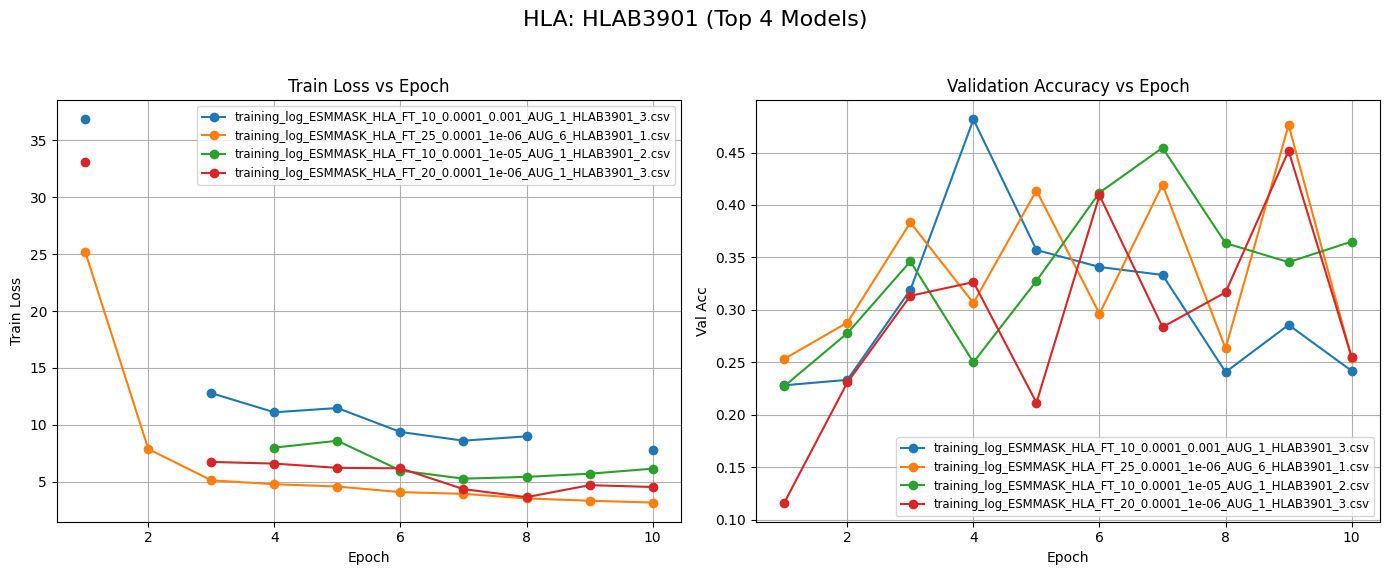

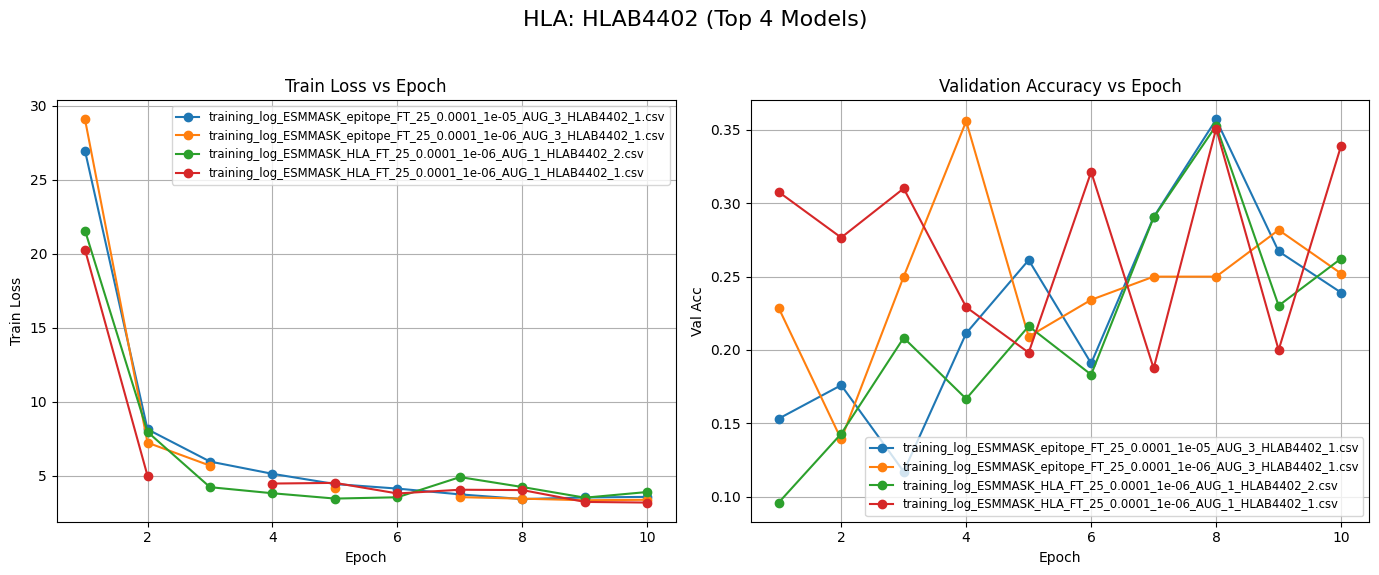

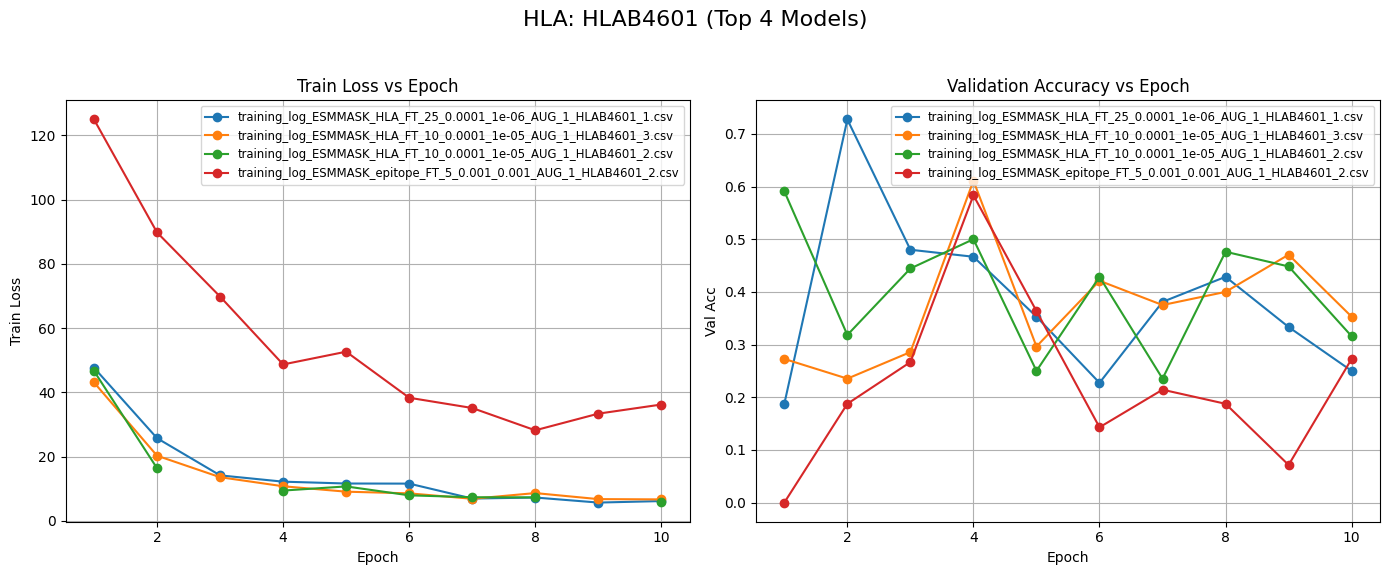

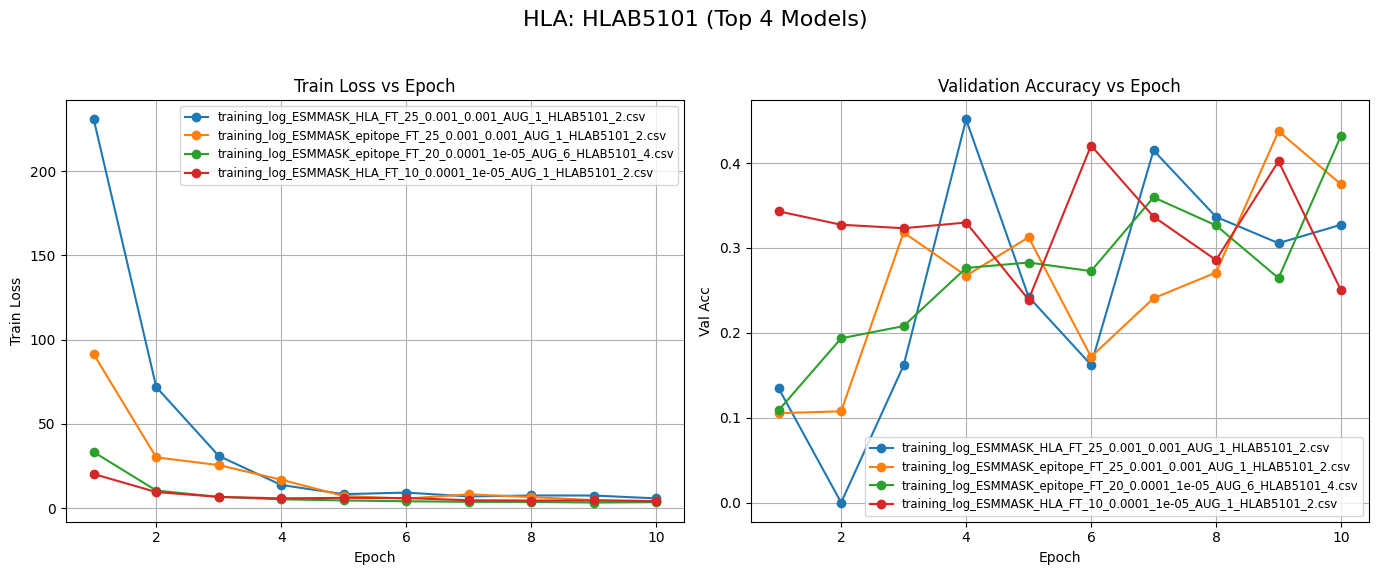

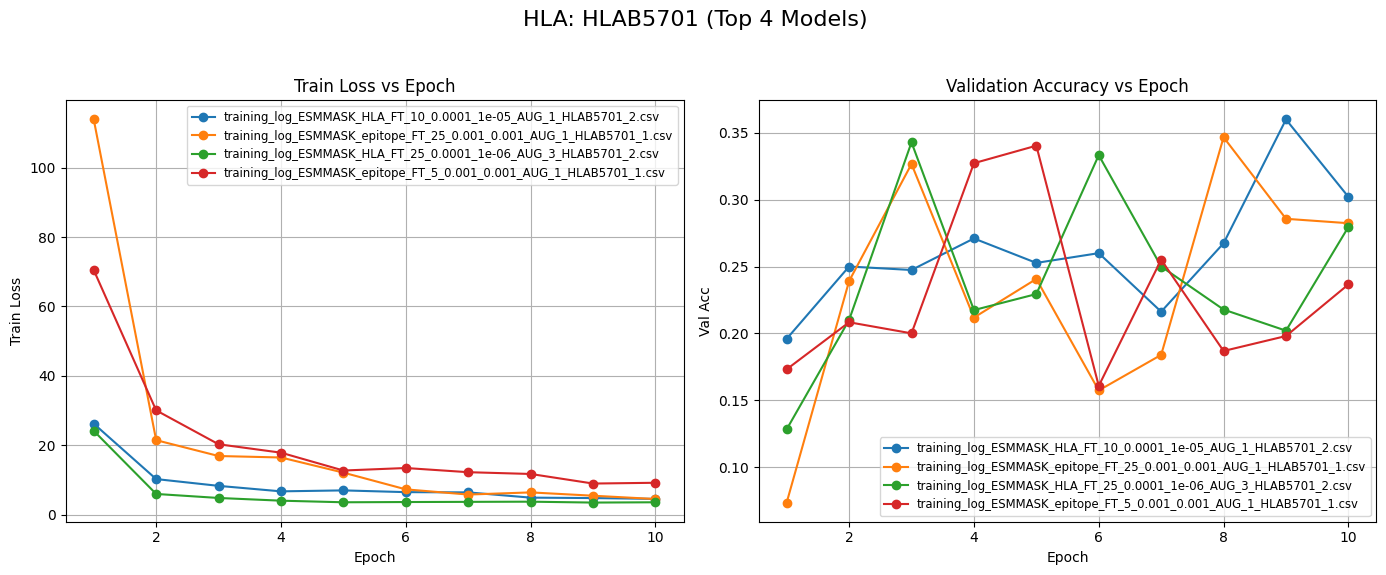

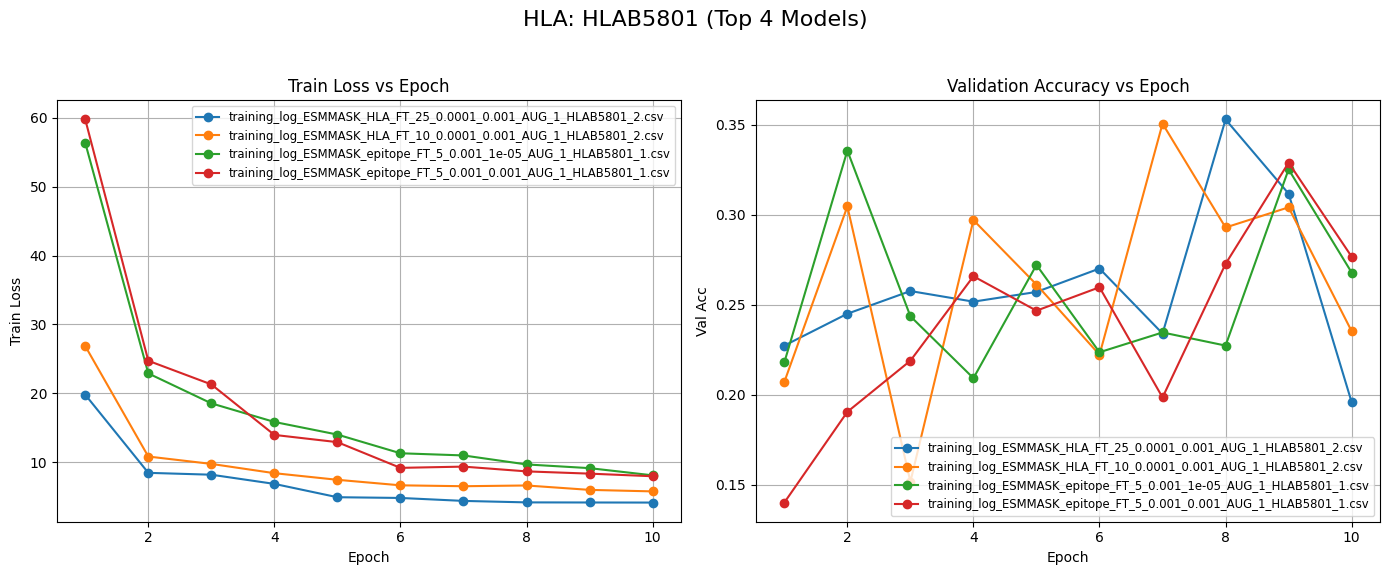

In [2]:

# Define the directory where CSV files are stored.
directory = '/global/scratch/users/sergiomar10/logs/ESMC_Pretrain_logs'
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# List to store summary info from each CSV file.
data = []

# Loop over each CSV file.
for file in csv_files:
    if os.path.getsize(file) > 0:
        try:
            df = pd.read_csv(file)
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue
        
        # Extract HLA from the filename.
        # Assumes the HLA is the second-to-last token when splitting by '_'.
        base = os.path.basename(file)
        parts = base.split('_')
        hla = parts[-2] if len(parts) >= 2 else 'Unknown'
        
        # Compute the maximum validation accuracy if available.
        if 'Val Acc' in df.columns:
            max_val_acc = df['Val Acc'].max()
        else:
            max_val_acc = None
        
        data.append({'file': file, 'filename': base, 'HLA': hla, 'max_val_acc': max_val_acc})

# Create a summary DataFrame.
df_summary = pd.DataFrame(data)

# Group by HLA and then process each group.
grouped = df_summary.groupby('HLA')

for hla, group in grouped:
    # Sort the group by max validation accuracy in descending order and take the top 10 models.
    group_sorted = group.sort_values(by='max_val_acc', ascending=False).head(4)
    
    # Create a figure with two subplots: one for Train Loss, one for Val Acc.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'HLA: {hla} (Top {len(group_sorted)} Models)', fontsize=16)
    
    # Loop through the top models for this HLA.
    for _, row in group_sorted.iterrows():
        file = row['file']
        try:
            df = pd.read_csv(file)
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue
        
        label = row['filename']
        
        # Plot Train Loss vs Epoch if columns exist.
        if 'Epoch' in df.columns and 'Train Loss' in df.columns:
            ax1.plot(df['Epoch'], df['Train Loss'], marker='o', label=label)
        # Plot Val Acc vs Epoch if columns exist.
        if 'Epoch' in df.columns and 'Val Acc' in df.columns:
            ax2.plot(df['Epoch'], df['Val Acc'], marker='o', label=label)
    
    # Customize the Train Loss subplot.
    ax1.set_title('Train Loss vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.legend(fontsize='small', loc='best')
    ax1.grid(True)
    
    # Customize the Validation Accuracy subplot.
    ax2.set_title('Validation Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Val Acc')
    ax2.legend(fontsize='small', loc='best')
    ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [48]:
import datetime
sorted_acuraccies = []

for file_name in glob.glob('/global/scratch/users/sergiomar10/models/ESMC_Pretrain/*/*.pt'):

    try:
        file_name = file_name.split('/')[-1].replace('.pt', '.csv')
        file_name = f'/global/scratch/users/sergiomar10/data/ESMC_Pretrain/{file_name}'
        eval_df = pd.read_csv(file_name)
        eval_df = eval_df[eval_df['original_aa'] != '<eos>']
        eval_df['correct'] = eval_df['original_aa'] == eval_df['predicted_aa']
        eval_df['file'] = file_name
    
        size_of_eval_set = len(eval_df)
        
        creation_time = os.path.getctime(file_name)
        creation_date = datetime.datetime.fromtimestamp(creation_time)
        
        acuraccy = len(eval_df[eval_df['correct'] == 1]) /  len(eval_df)
        
        # if acuraccy > 0.25:
        sorted_acuraccies.append([file_name, creation_date, size_of_eval_set, acuraccy])
    except:
        print(file_name)

# eval_acc = pd.DataFrame(sorted_acuraccies).sort_values(by = 1, ascending = False)

/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0101_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_0.001_AUG_1_HLAA0101_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_1e-06_AUG_6_HLAA0301_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0301_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_3.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_HLA_FT_10_0.0001_0.001_AUG_1_HLAA0206_2.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_5_0.001_1e-06_AUG_6_HLAA0202_1.csv
/global/scratch/users/sergiomar10/data/ESMC_Pretr

In [49]:
eval_acc = pd.DataFrame(sorted_acuraccies)
eval_acc.columns = ['file', 'date', 'eval_set_size', 'accuracy']
eval_acc = eval_acc[eval_acc['accuracy'] < 0.8]
eval_acc['file'] = eval_acc['file'].str.split('/', expand = True)[7]
eval_acc['finetuned_blocks'] = eval_acc['file'].str.split('_', expand = True)[3]
eval_acc['transformer_lr'] = eval_acc['file'].str.split('_', expand = True)[4]
eval_acc['reg_lr'] = eval_acc['file'].str.split('_', expand = True)[5]
eval_acc['AUG'] = eval_acc['file'].str.split('_', expand = True)[7]
eval_acc['AUG'] = eval_acc['AUG'].astype('int')
eval_acc['HLA'] = eval_acc['file'].str.split('_', expand = True)[8]
eval_acc['Encoding'] = eval_acc['file'].str.split('_', expand = True)[1]

In [50]:
# eval_acc = eval_acc[eval_acc['AUG'] ==1 ]

In [51]:
eval_acc.sort_values(by='accuracy', ascending=False) \
        .drop_duplicates(subset=['HLA', 'Encoding']) \
        .to_csv('ESMCBA_models.csv', index=None)

In [52]:
eval_acc['HLA'].nunique()

29

In [53]:
eval_acc.sort_values(by='accuracy', ascending=False) \
        .drop_duplicates(subset=['HLA', 'Encoding'])

file                date  \
57   ESMMASK_HLA_FT_25_0.0001_0.001_AUG_6_HLAB4601_... 2025-03-03 13:00:15   
131  ESMMASK_HLA_FT_25_0.001_1e-05_AUG_1_HLAA2403_1... 2025-03-03 13:32:01   
61   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_1_HLAB4... 2025-03-02 16:09:41   
37   ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_6_HLAB5101_... 2025-03-03 15:00:24   
32   ESMMASK_epitope_FT_25_0.0001_0.001_AUG_6_HLAB5... 2025-03-03 14:33:35   
119  ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_6_HLAB3901_... 2025-03-03 15:22:13   
77   ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_1_HLAB3501_... 2025-03-03 15:48:18   
130  ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA24... 2025-03-03 15:14:51   
4    ESMMASK_HLA_FT_25_0.0001_0.001_AUG_3_HLAA0101_... 2025-03-03 15:20:38   
0    ESMMASK_epitope_FT_25_0.001_1e-05_AUG_6_HLAA01... 2025-03-03 14:19:54   
46   ESMMASK_HLA_FT_25_0.001_1e-05_AUG_3_HLAA2601_2... 2025-03-03 15:07:47   
161  ESMMASK_HLA_FT_25_0.0001_1e-05_AUG_1_HLAB5701_... 2025-03-03 14:59:48   
145  ESMMASK_epitope_FT_25_0.001_0.001_AUG_6_HLAA11... 2025-03-03 15:20:59   
50   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_6_HLAA0... 2025-03-03 16:00:04   
110  ESMMASK_epitope_FT_25_0.001_0.001_AUG_3_HLAB15... 2025-03-03 15:33:30   
101  ESMMASK_epitope_FT_25_0.0001_1e-06_AUG_3_HLAA3... 2025-03-03 14:18:43   
92   ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_1_HLAB1517_... 2025-03-03 14:47:40   
83   ESMMASK_epitope_FT_25_0.001_0.001_AUG_3_HLAB08... 2025-03-03 16:03:23   
89   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_6_HLAB1... 2025-03-03 14:52:22   
152  ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_3_HLAB4402_... 2025-03-03 14:16:48   
16   ESMMASK_epitope_FT_15_0.0001_0.001_AUG_6_HLAB5... 2025-03-03 16:00:28   
91   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_6_HLAB1... 2025-03-03 15:56:19   
19   ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA0301_... 2025-03-03 15:51:30   
79   ESMMASK_epitope_FT_5_0.001_1e-05_AUG_1_HLAB350... 2025-03-02 22:25:00   
85   ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAB0801_... 2025-03-03 15:32:10   
71   ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_1_HLAA2902_... 2025-03-03 14:51:07   
109  ESMMASK_epitope_FT_25_0.001_0.001_AUG_3_HLAB07... 2025-03-03 15:59:46   
154  ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_6_HLAB4... 2025-03-03 14:39:36   
20   ESMMASK_epitope_FT_25_0.001_0.001_AUG_6_HLAA03... 2025-03-03 15:34:02   
42   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_3_HLAA6... 2025-03-03 15:58:50   
108  ESMMASK_HLA_FT_25_0.001_1e-05_AUG_1_HLAB0702_2... 2025-03-03 14:20:40   
146  ESMMASK_HLA_FT_25_0.001_0.001_AUG_3_HLAA1101_2... 2025-03-03 15:53:42   
121  ESMMASK_epitope_FT_25_0.001_1e-05_AUG_1_HLAA68... 2025-03-03 15:05:17   
21   ESMMASK_epitope_FT_25_0.0001_1e-06_AUG_1_HLAA0... 2025-03-03 14:20:26   
69   ESMMASK_epitope_FT_25_0.001_0.001_AUG_6_HLAA02... 2025-03-03 15:15:05   
106  ESMMASK_epitope_FT_25_0.001_1e-05_AUG_6_HLAA68... 2025-03-03 14:39:11   
114  ESMMASK_HLA_FT_25_0.0001_0.001_AUG_6_HLAB1501_... 2025-03-03 15:35:38   
127  ESMMASK_HLA_FT_25_0.0001_1e-05_AUG_1_HLAA6801_... 2025-03-03 15:41:15   
105  ESMMASK_HLA_FT_25_0.0001_1e-06_AUG_6_HLAA6802_... 2025-03-03 15:16:57   
27   ESMMASK_epitope_FT_25_0.001_1e-05_AUG_6_HLAA30... 2025-03-03 14:22:09   
95   ESMMASK_epitope_FT_25_0.0001_1e-06_AUG_3_HLAA2... 2025-03-03 14:36:54   
43   ESMMASK_epitope_FT_15_0.0001_1e-05_AUG_1_HLAA2... 2025-03-03 14:51:08   
72   ESMMASK_epitope_FT_25_0.0001_1e-05_AUG_1_HLAA2... 2025-03-03 15:03:59   
28   ESMMASK_HLA_FT_25_0.001_1e-06_AUG_1_HLAA3002_1... 2025-03-03 15:24:48   
68   ESMMASK_HLA_FT_25_0.001_1e-05_AUG_1_HLAA0203_2... 2025-03-03 15:53:16   
51   ESMMASK_HLA_FT_25_0.0001_1e-05_AUG_3_HLAA0202_... 2025-03-03 15:26:11   
88   ESMMASK_epitope_FT_20_0.0001_1e-05_AUG_3_HLAA3... 2025-03-03 14:56:50   
160  ESMMASK_epitope_FT_25_0.001_1e-05_AUG_1_HLAB57... 2025-03-03 14:39:24   
66   ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA2301_... 2025-03-03 15:57:09   
102  ESMMASK_HLA_FT_25_0.0001_0.001_AUG_1_HLAA3001_... 2025-03-03 14:29:48   
26   ESMMASK_HLA_FT_25_0.001_0.001_AUG_1_HLAA0206_2... 2025-03-03 14:35:

In [19]:
from collections import Counter

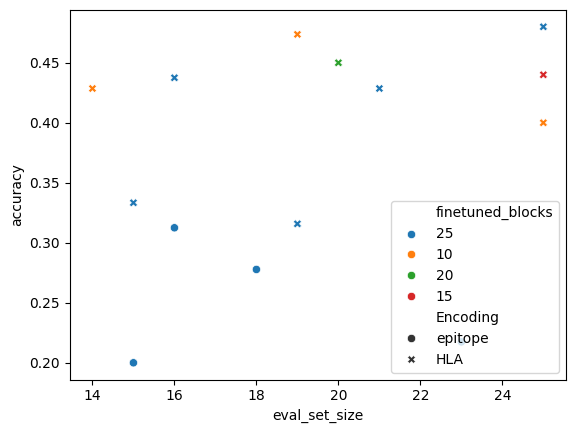

In [35]:
sns.scatterplot(data = eval_acc[eval_acc['HLA'] == 'HLAB4601'],
                x = 'eval_set_size', y = 'accuracy',
                hue = 'finetuned_blocks', style='Encoding')
plt.show()

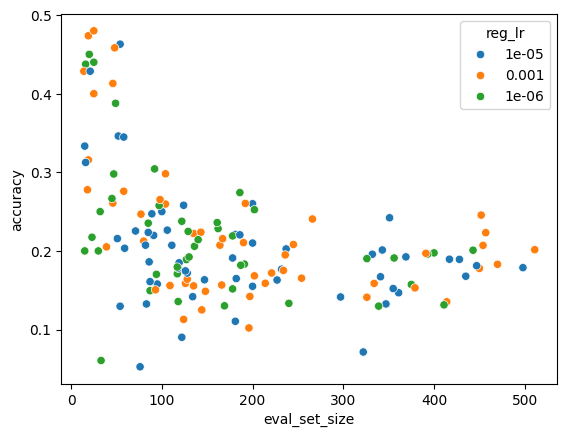

In [36]:
sns.scatterplot(data = eval_acc, x = 'eval_set_size', y = 'accuracy', hue = 'reg_lr')
# plt.xscale('log')
plt.show()

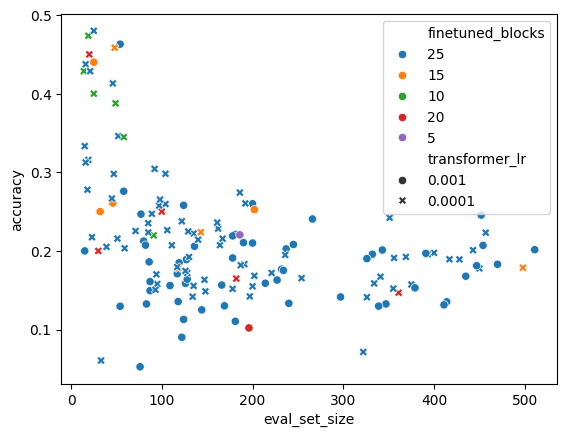

In [38]:
sns.scatterplot(data = eval_acc, x = 'eval_set_size', y = 'accuracy', hue = 'finetuned_blocks', style ='transformer_lr')
plt.show()

In [23]:
evals_hla = eval_acc.sort_values(by = 'accuracy', ascending =False).drop_duplicates('HLA').head(30)

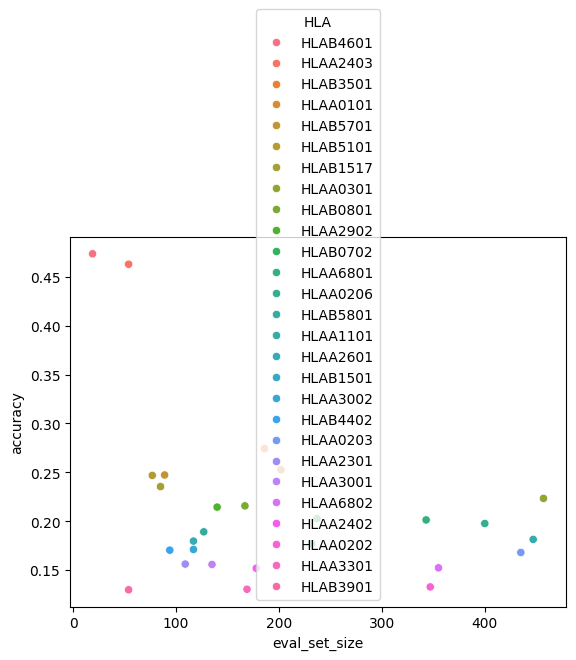

In [39]:
sns.scatterplot(data = evals_hla, x = 'eval_set_size', y = 'accuracy', hue = 'HLA')
# plt.xscale('log')
plt.show()

In [25]:
eval_df = pd.read_csv('/global/scratch/users/sergiomar10/data/ESMC_Pretrain/ESMMASK_epitope_FT_25_0.001_1e-06_AUG_6_HLAA0301_2.csv')

In [26]:

eval_df = eval_df[eval_df['original_aa'] != '<eos>']
eval_df['correct'] = eval_df['original_aa'] == eval_df['predicted_aa']
eval_df['file'] = file_name
acuraccy = len(eval_df[eval_df['correct'] == 1]) /  len(eval_df)

In [27]:
acuraccy

0.21333333333333335

### Create SLURM files

In [40]:
################################################
# 6. Define a simple FASTA parser
################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        # Append the last sequence if present
        if seq:
            sequences.append((header, seq))
    return sequences


############################################
# 7. Load and filter the data
############################################
train_fasta = "/global/scratch/users/sergiomar10/jupyter_notebooks/hla_protein_sequences.fasta"
all_data = parse_fasta(train_fasta)

filtered_data = []
for header, sequence in all_data:
    if sequence[0] != 'M':
        continue
    if len(sequence) < 50:
        continue
    if 'X' in sequence:
        continue

    header = header.split('|')[1][:7].replace('*','').replace(':','')

    filtered_data.append(('HLA' + header))
    

In [47]:
[x for x in filtered_data if x not in eval_acc['HLA'].unique()]

['HLAA0201']

In [9]:
import itertools
import os
import glob

script_path = '/global/scratch/users/sergiomar10/py_files/ESM-C_ALLHLAs.py'
sh_file_dir = '/global/scratch/users/sergiomar10/slurm_jobs/ESMC_Pretrain2'
os.makedirs(sh_file_dir, exist_ok=True)

trials = [3, 4, 5]
encoding = ['epitope', 'HLA']
blocks_unfrozen = [15, 20, 25]
last_block_lr = [1e-3, 1e-4]
regression_block_lr = [1e-3, 1e-5, 1e-6]
HLAs = filtered_data
num_augmentations = [1, 3, 6]
                    
for trial_n, encode, num_block, lr_base, lr_reg, HLA, augs  in itertools.product(trials, encoding, blocks_unfrozen, last_block_lr, regression_block_lr, HLAs, num_augmentations):
    
    file_name = f'ESMMASK_{encode}_FT_{num_block}_{lr_base}_{lr_reg}_AUG_{augs}_{HLA}_{trial_n}'

    sh_filename = f'{file_name}.sh'
    sh_filepath = os.path.join(sh_file_dir, sh_filename)
    
    # Construct the command to run the script with the current parameters
    cmd = f'python3 {script_path} --name_of_model {file_name} --encoding {encode} --blocks_unfrozen {num_block} --base_block_lr {lr_base} --regression_block_lr {lr_reg} --HLA {HLA} --num_augmentations {augs}'

    with open(sh_filepath, 'w') as sh_file:
        sh_file.write('#!/bin/bash\n')
        sh_file.write('#SBATCH --account=co_nilah\n')
        sh_file.write('#SBATCH --partition=savio2_1080ti\n')
        sh_file.write('#SBATCH --qos=savio_lowprio\n')
        sh_file.write('#SBATCH --cpus-per-task=4\n')
        sh_file.write('#SBATCH --gres=gpu:1\n')
        sh_file.write('#SBATCH --requeue\n')
        sh_file.write('#SBATCH --time=00:20:00\n')
        sh_file.write(f'#SBATCH --job-name={file_name}\n')
        sh_file.write(f'#SBATCH --output=/global/scratch/users/sergiomar10/logs/ESMC_Pretrain/{file_name}_%j.out\n')
        sh_file.write(f'#SBATCH --error=/global/scratch/users/sergiomar10/logs/ESMC_Pretrain/{file_name}_%j.err\n')
        sh_file.write('source /clusterfs/nilah/sergio/miniconda3/etc/profile.d/conda.sh\n')
        sh_file.write('\n')
        sh_file.write('conda activate ESM_cambrian\n')
        sh_file.write('\n')

        sh_file.write(cmd + '\n')
        
    # Make the shell script executable
    os.chmod(sh_filepath, 0o755)
    
    print(f'Created shell script: {file_name}')




Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0101_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0201_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0202_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_3_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_6_HLAA0203_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0.001_AUG_1_HLAA0206_3
Created shell script: ESMMASK_epitope_FT_15_0.001_0

### Masking evaluationsn